In [19]:
!pip install transformers==3.4.0

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [20]:
import pandas as pd
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
import transformers
from tensorflow.keras.models import Model
from keras.layers.core import Dense, Dropout
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
import matplotlib.pyplot as plt
import numpy as np

In [21]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

Running on TPU  grpc://10.0.0.2:8470


In [22]:
train = pd.read_csv('../input/dataset-modified/train_modified.csv')
valid = pd.read_csv('../input/dataset-modified/val_modified.csv')
test = pd.read_csv('../input/dataset-modified/test_modified.csv')

xtrain, ytrain = train.Comment.values, train.Emotion.values
xvalid, yvalid = valid.Comment.values, valid.Emotion.values
xtest, ytest = test.Comment.values, test.Emotion.values

In [23]:
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = 'bert-base-multilingual-cased')
max_len = 200

xtrain_pad = tokenizer(
    text=train['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

xvalid_pad = tokenizer(
    text=valid['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

In [24]:
def build_model(transformer):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    sequence_output = transformer(input_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(4, activation='softmax')(cls_token)

    model = Model(inputs=input_ids, outputs=out)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(Adam(lr=1e-5, beta_2 = 0.50), loss=loss, metrics=['accuracy'])

    return model

In [25]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

with strategy.scope():
    model_name = 'bert-base-multilingual-cased'
    config = BertConfig.from_pretrained(model_name)
    config.output_hidden_states = False
    transformer_model = TFBertModel.from_pretrained(model_name, config = config)
    model = build_model(transformer_model)
    
model.summary()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
tf_bert_model_1 (TFBertModel ((None, 200, 768), (None, 177853440 
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 768)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 3076      
Total params: 177,856,516
Trainable params: 177,856,516
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(xtrain_pad['input_ids'], ytrain,epochs=100, validation_data= (xvalid_pad['input_ids'], yvalid), batch_size=32) 

Epoch 1/100
94/94 [==============================] - ETA: 0s - loss: 1.4247 - accuracy: 0.18 - ETA: 4s - loss: 1.4467 - accuracy: 0.14 - ETA: 5s - loss: 1.4142 - accuracy: 0.21 - ETA: 6s - loss: 1.4129 - accuracy: 0.23 - ETA: 6s - loss: 1.4096 - accuracy: 0.25 - ETA: 6s - loss: 1.4064 - accuracy: 0.26 - ETA: 6s - loss: 1.4075 - accuracy: 0.25 - ETA: 7s - loss: 1.4068 - accuracy: 0.23 - ETA: 7s - loss: 1.4050 - accuracy: 0.24 - ETA: 7s - loss: 1.4047 - accuracy: 0.24 - ETA: 7s - loss: 1.4067 - accuracy: 0.23 - ETA: 7s - loss: 1.4055 - accuracy: 0.23 - ETA: 7s - loss: 1.4060 - accuracy: 0.22 - ETA: 7s - loss: 1.4022 - accuracy: 0.24 - ETA: 7s - loss: 1.4020 - accuracy: 0.24 - ETA: 7s - loss: 1.4028 - accuracy: 0.24 - ETA: 7s - loss: 1.4052 - accuracy: 0.23 - ETA: 6s - loss: 1.4055 - accuracy: 0.23 - ETA: 6s - loss: 1.4045 - accuracy: 0.23 - ETA: 6s - loss: 1.4016 - accuracy: 0.24 - ETA: 6s - loss: 1.4003 - accuracy: 0.25 - ETA: 6s - loss: 1.4010 - accuracy: 0.24 - ETA: 6s - loss: 1.3997 

Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 1.4052 - accuracy: 0.25 - ETA: 4s - loss: 1.4141 - accuracy: 0.23 - ETA: 8s - loss: 1.4082 - accuracy: 0.22 - ETA: 9s - loss: 1.4174 - accuracy: 0.21 - ETA: 9s - loss: 1.4206 - accuracy: 0.19 - ETA: 8s - loss: 1.4192 - accuracy: 0.20 - ETA: 8s - loss: 1.4173 - accuracy: 0.20 - ETA: 8s - loss: 1.4132 - accuracy: 0.20 - ETA: 8s - loss: 1.4132 - accuracy: 0.20 - ETA: 8s - loss: 1.4104 - accuracy: 0.20 - ETA: 8s - loss: 1.4097 - accuracy: 0.21 - ETA: 7s - loss: 1.4083 - accuracy: 0.21 - ETA: 7s - loss: 1.4079 - accuracy: 0.20 - ETA: 7s - loss: 1.4071 - accuracy: 0.20 - ETA: 7s - loss: 1.4060 - accuracy: 0.20 - ETA: 7s - loss: 1.4053 - accuracy: 0.20 - ETA: 7s - loss: 1.4048 - accuracy: 0.20 - ETA: 7s - loss: 1.4047 - accuracy: 0.20 - ETA: 7s - loss: 1.4029 - accuracy: 0.21 - ETA: 7s - loss: 1.4015 - accuracy: 0.21 - ETA: 7s - loss: 1.4031 - accuracy: 0.21 - ETA: 6s - loss: 1.4002 - accuracy: 0.22 - ETA: 6s - loss: 1.4008 

Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 1.3982 - accuracy: 0.18 - ETA: 4s - loss: 1.3930 - accuracy: 0.21 - ETA: 5s - loss: 1.3896 - accuracy: 0.25 - ETA: 6s - loss: 1.3921 - accuracy: 0.22 - ETA: 6s - loss: 1.3920 - accuracy: 0.23 - ETA: 6s - loss: 1.3917 - accuracy: 0.24 - ETA: 6s - loss: 1.3916 - accuracy: 0.23 - ETA: 6s - loss: 1.3918 - accuracy: 0.22 - ETA: 6s - loss: 1.3916 - accuracy: 0.22 - ETA: 6s - loss: 1.3910 - accuracy: 0.23 - ETA: 6s - loss: 1.3897 - accuracy: 0.24 - ETA: 6s - loss: 1.3901 - accuracy: 0.23 - ETA: 6s - loss: 1.3897 - accuracy: 0.24 - ETA: 6s - loss: 1.3904 - accuracy: 0.23 - ETA: 6s - loss: 1.3903 - accuracy: 0.23 - ETA: 6s - loss: 1.3903 - accuracy: 0.23 - ETA: 6s - loss: 1.3901 - accuracy: 0.23 - ETA: 6s - loss: 1.3904 - accuracy: 0.23 - ETA: 6s - loss: 1.3896 - accuracy: 0.24 - ETA: 6s - loss: 1.3894 - accuracy: 0.24 - ETA: 6s - loss: 1.3889 - accuracy: 0.24 - ETA: 6s - loss: 1.3888 - accuracy: 0.25 - ETA: 6s - loss: 1.3883 

Epoch 7/100
94/94 [==============================] - ETA: 0s - loss: 1.3810 - accuracy: 0.28 - ETA: 4s - loss: 1.3802 - accuracy: 0.26 - ETA: 5s - loss: 1.3923 - accuracy: 0.25 - ETA: 6s - loss: 1.3978 - accuracy: 0.23 - ETA: 6s - loss: 1.3899 - accuracy: 0.26 - ETA: 6s - loss: 1.3921 - accuracy: 0.25 - ETA: 6s - loss: 1.3926 - accuracy: 0.24 - ETA: 6s - loss: 1.3922 - accuracy: 0.23 - ETA: 6s - loss: 1.3933 - accuracy: 0.22 - ETA: 6s - loss: 1.3945 - accuracy: 0.21 - ETA: 6s - loss: 1.3936 - accuracy: 0.21 - ETA: 6s - loss: 1.3957 - accuracy: 0.21 - ETA: 6s - loss: 1.3961 - accuracy: 0.20 - ETA: 6s - loss: 1.3959 - accuracy: 0.20 - ETA: 6s - loss: 1.3953 - accuracy: 0.21 - ETA: 6s - loss: 1.3952 - accuracy: 0.21 - ETA: 6s - loss: 1.3942 - accuracy: 0.21 - ETA: 6s - loss: 1.3953 - accuracy: 0.21 - ETA: 6s - loss: 1.3951 - accuracy: 0.21 - ETA: 6s - loss: 1.3951 - accuracy: 0.21 - ETA: 6s - loss: 1.3945 - accuracy: 0.21 - ETA: 6s - loss: 1.3944 - accuracy: 0.21 - ETA: 6s - loss: 1.3939 

Epoch 9/100
94/94 [==============================] - ETA: 0s - loss: 1.3084 - accuracy: 0.40 - ETA: 4s - loss: 1.3402 - accuracy: 0.35 - ETA: 5s - loss: 1.3569 - accuracy: 0.35 - ETA: 6s - loss: 1.3558 - accuracy: 0.35 - ETA: 6s - loss: 1.3652 - accuracy: 0.34 - ETA: 6s - loss: 1.3572 - accuracy: 0.35 - ETA: 6s - loss: 1.3635 - accuracy: 0.34 - ETA: 6s - loss: 1.3647 - accuracy: 0.33 - ETA: 6s - loss: 1.3571 - accuracy: 0.34 - ETA: 6s - loss: 1.3560 - accuracy: 0.34 - ETA: 6s - loss: 1.3591 - accuracy: 0.33 - ETA: 6s - loss: 1.3581 - accuracy: 0.33 - ETA: 6s - loss: 1.3597 - accuracy: 0.33 - ETA: 6s - loss: 1.3598 - accuracy: 0.32 - ETA: 6s - loss: 1.3625 - accuracy: 0.32 - ETA: 6s - loss: 1.3600 - accuracy: 0.32 - ETA: 6s - loss: 1.3587 - accuracy: 0.33 - ETA: 6s - loss: 1.3577 - accuracy: 0.33 - ETA: 6s - loss: 1.3579 - accuracy: 0.33 - ETA: 6s - loss: 1.3573 - accuracy: 0.33 - ETA: 6s - loss: 1.3558 - accuracy: 0.34 - ETA: 6s - loss: 1.3559 - accuracy: 0.33 - ETA: 6s - loss: 1.3535 

Epoch 11/100
94/94 [==============================] - ETA: 0s - loss: 1.2181 - accuracy: 0.50 - ETA: 4s - loss: 1.1964 - accuracy: 0.51 - ETA: 5s - loss: 1.2098 - accuracy: 0.53 - ETA: 6s - loss: 1.1963 - accuracy: 0.53 - ETA: 6s - loss: 1.1930 - accuracy: 0.53 - ETA: 6s - loss: 1.1795 - accuracy: 0.55 - ETA: 6s - loss: 1.1776 - accuracy: 0.54 - ETA: 6s - loss: 1.1868 - accuracy: 0.52 - ETA: 6s - loss: 1.1790 - accuracy: 0.52 - ETA: 6s - loss: 1.1771 - accuracy: 0.52 - ETA: 6s - loss: 1.1760 - accuracy: 0.52 - ETA: 6s - loss: 1.1793 - accuracy: 0.52 - ETA: 6s - loss: 1.1740 - accuracy: 0.53 - ETA: 6s - loss: 1.1676 - accuracy: 0.54 - ETA: 6s - loss: 1.1693 - accuracy: 0.54 - ETA: 6s - loss: 1.1713 - accuracy: 0.54 - ETA: 6s - loss: 1.1630 - accuracy: 0.55 - ETA: 6s - loss: 1.1570 - accuracy: 0.55 - ETA: 6s - loss: 1.1561 - accuracy: 0.56 - ETA: 6s - loss: 1.1519 - accuracy: 0.57 - ETA: 6s - loss: 1.1550 - accuracy: 0.56 - ETA: 6s - loss: 1.1520 - accuracy: 0.57 - ETA: 6s - loss: 1.1500

Epoch 13/100
94/94 [==============================] - ETA: 0s - loss: 0.9338 - accuracy: 0.81 - ETA: 4s - loss: 0.9253 - accuracy: 0.81 - ETA: 5s - loss: 0.9922 - accuracy: 0.73 - ETA: 6s - loss: 0.9958 - accuracy: 0.74 - ETA: 6s - loss: 1.0093 - accuracy: 0.73 - ETA: 6s - loss: 1.0264 - accuracy: 0.72 - ETA: 6s - loss: 1.0337 - accuracy: 0.71 - ETA: 6s - loss: 1.0367 - accuracy: 0.70 - ETA: 7s - loss: 1.0423 - accuracy: 0.69 - ETA: 6s - loss: 1.0469 - accuracy: 0.69 - ETA: 6s - loss: 1.0505 - accuracy: 0.68 - ETA: 6s - loss: 1.0590 - accuracy: 0.67 - ETA: 6s - loss: 1.0533 - accuracy: 0.68 - ETA: 6s - loss: 1.0433 - accuracy: 0.69 - ETA: 6s - loss: 1.0440 - accuracy: 0.69 - ETA: 7s - loss: 1.0437 - accuracy: 0.69 - ETA: 7s - loss: 1.0413 - accuracy: 0.69 - ETA: 7s - loss: 1.0421 - accuracy: 0.69 - ETA: 6s - loss: 1.0434 - accuracy: 0.69 - ETA: 6s - loss: 1.0439 - accuracy: 0.69 - ETA: 6s - loss: 1.0520 - accuracy: 0.68 - ETA: 6s - loss: 1.0538 - accuracy: 0.68 - ETA: 6s - loss: 1.0522

Epoch 15/100
94/94 [==============================] - ETA: 0s - loss: 1.0360 - accuracy: 0.68 - ETA: 4s - loss: 1.0190 - accuracy: 0.71 - ETA: 5s - loss: 1.0247 - accuracy: 0.70 - ETA: 6s - loss: 1.0403 - accuracy: 0.69 - ETA: 6s - loss: 1.0525 - accuracy: 0.68 - ETA: 6s - loss: 1.0498 - accuracy: 0.68 - ETA: 6s - loss: 1.0376 - accuracy: 0.69 - ETA: 6s - loss: 1.0150 - accuracy: 0.71 - ETA: 6s - loss: 1.0143 - accuracy: 0.71 - ETA: 6s - loss: 1.0248 - accuracy: 0.70 - ETA: 6s - loss: 1.0163 - accuracy: 0.71 - ETA: 6s - loss: 1.0107 - accuracy: 0.72 - ETA: 6s - loss: 1.0124 - accuracy: 0.72 - ETA: 6s - loss: 1.0169 - accuracy: 0.71 - ETA: 6s - loss: 1.0119 - accuracy: 0.72 - ETA: 6s - loss: 1.0125 - accuracy: 0.72 - ETA: 6s - loss: 1.0146 - accuracy: 0.72 - ETA: 6s - loss: 1.0114 - accuracy: 0.72 - ETA: 6s - loss: 1.0037 - accuracy: 0.73 - ETA: 6s - loss: 1.0060 - accuracy: 0.73 - ETA: 6s - loss: 1.0014 - accuracy: 0.73 - ETA: 6s - loss: 1.0016 - accuracy: 0.73 - ETA: 6s - loss: 1.0002

Epoch 17/100
94/94 [==============================] - ETA: 0s - loss: 0.9602 - accuracy: 0.78 - ETA: 4s - loss: 0.9613 - accuracy: 0.78 - ETA: 5s - loss: 1.0139 - accuracy: 0.72 - ETA: 6s - loss: 1.0276 - accuracy: 0.71 - ETA: 6s - loss: 1.0419 - accuracy: 0.70 - ETA: 6s - loss: 1.0336 - accuracy: 0.71 - ETA: 6s - loss: 1.0265 - accuracy: 0.71 - ETA: 6s - loss: 1.0341 - accuracy: 0.71 - ETA: 6s - loss: 1.0275 - accuracy: 0.71 - ETA: 6s - loss: 1.0205 - accuracy: 0.72 - ETA: 6s - loss: 1.0271 - accuracy: 0.71 - ETA: 6s - loss: 1.0190 - accuracy: 0.72 - ETA: 6s - loss: 1.0121 - accuracy: 0.73 - ETA: 6s - loss: 1.0149 - accuracy: 0.73 - ETA: 6s - loss: 1.0154 - accuracy: 0.73 - ETA: 6s - loss: 1.0142 - accuracy: 0.73 - ETA: 6s - loss: 1.0149 - accuracy: 0.73 - ETA: 6s - loss: 1.0120 - accuracy: 0.73 - ETA: 6s - loss: 1.0127 - accuracy: 0.73 - ETA: 6s - loss: 1.0055 - accuracy: 0.74 - ETA: 6s - loss: 0.9990 - accuracy: 0.74 - ETA: 6s - loss: 1.0003 - accuracy: 0.74 - ETA: 6s - loss: 1.0044

Epoch 19/100
94/94 [==============================] - ETA: 0s - loss: 1.0085 - accuracy: 0.71 - ETA: 4s - loss: 0.9675 - accuracy: 0.76 - ETA: 5s - loss: 0.9760 - accuracy: 0.75 - ETA: 6s - loss: 0.9605 - accuracy: 0.76 - ETA: 6s - loss: 0.9560 - accuracy: 0.77 - ETA: 6s - loss: 0.9680 - accuracy: 0.76 - ETA: 6s - loss: 0.9659 - accuracy: 0.76 - ETA: 6s - loss: 0.9692 - accuracy: 0.76 - ETA: 6s - loss: 0.9706 - accuracy: 0.76 - ETA: 6s - loss: 0.9652 - accuracy: 0.76 - ETA: 6s - loss: 0.9639 - accuracy: 0.76 - ETA: 6s - loss: 0.9621 - accuracy: 0.77 - ETA: 6s - loss: 0.9568 - accuracy: 0.77 - ETA: 6s - loss: 0.9564 - accuracy: 0.77 - ETA: 6s - loss: 0.9605 - accuracy: 0.77 - ETA: 6s - loss: 0.9557 - accuracy: 0.78 - ETA: 6s - loss: 0.9559 - accuracy: 0.78 - ETA: 6s - loss: 0.9622 - accuracy: 0.77 - ETA: 6s - loss: 0.9618 - accuracy: 0.77 - ETA: 6s - loss: 0.9653 - accuracy: 0.77 - ETA: 6s - loss: 0.9641 - accuracy: 0.77 - ETA: 6s - loss: 0.9600 - accuracy: 0.77 - ETA: 6s - loss: 0.9547

Epoch 21/100
94/94 [==============================] - ETA: 0s - loss: 0.9308 - accuracy: 0.81 - ETA: 4s - loss: 0.9457 - accuracy: 0.79 - ETA: 5s - loss: 0.9201 - accuracy: 0.82 - ETA: 6s - loss: 0.9387 - accuracy: 0.80 - ETA: 6s - loss: 0.9213 - accuracy: 0.82 - ETA: 6s - loss: 0.9330 - accuracy: 0.80 - ETA: 6s - loss: 0.9233 - accuracy: 0.81 - ETA: 6s - loss: 0.9241 - accuracy: 0.81 - ETA: 6s - loss: 0.9185 - accuracy: 0.82 - ETA: 6s - loss: 0.9149 - accuracy: 0.82 - ETA: 6s - loss: 0.9208 - accuracy: 0.82 - ETA: 7s - loss: 0.9234 - accuracy: 0.81 - ETA: 7s - loss: 0.9238 - accuracy: 0.81 - ETA: 7s - loss: 0.9232 - accuracy: 0.81 - ETA: 7s - loss: 0.9316 - accuracy: 0.80 - ETA: 7s - loss: 0.9237 - accuracy: 0.81 - ETA: 6s - loss: 0.9223 - accuracy: 0.81 - ETA: 6s - loss: 0.9159 - accuracy: 0.82 - ETA: 6s - loss: 0.9102 - accuracy: 0.83 - ETA: 6s - loss: 0.9126 - accuracy: 0.82 - ETA: 6s - loss: 0.9179 - accuracy: 0.82 - ETA: 6s - loss: 0.9186 - accuracy: 0.82 - ETA: 6s - loss: 0.9170

Epoch 23/100
94/94 [==============================] - ETA: 0s - loss: 0.9764 - accuracy: 0.75 - ETA: 4s - loss: 0.9061 - accuracy: 0.82 - ETA: 5s - loss: 0.8999 - accuracy: 0.83 - ETA: 6s - loss: 0.9102 - accuracy: 0.82 - ETA: 6s - loss: 0.9266 - accuracy: 0.81 - ETA: 6s - loss: 0.9220 - accuracy: 0.81 - ETA: 6s - loss: 0.9288 - accuracy: 0.81 - ETA: 6s - loss: 0.9351 - accuracy: 0.80 - ETA: 6s - loss: 0.9277 - accuracy: 0.81 - ETA: 6s - loss: 0.9243 - accuracy: 0.81 - ETA: 6s - loss: 0.9224 - accuracy: 0.81 - ETA: 6s - loss: 0.9308 - accuracy: 0.80 - ETA: 6s - loss: 0.9304 - accuracy: 0.81 - ETA: 6s - loss: 0.9296 - accuracy: 0.81 - ETA: 6s - loss: 0.9277 - accuracy: 0.81 - ETA: 6s - loss: 0.9259 - accuracy: 0.81 - ETA: 6s - loss: 0.9225 - accuracy: 0.81 - ETA: 6s - loss: 0.9178 - accuracy: 0.82 - ETA: 6s - loss: 0.9185 - accuracy: 0.82 - ETA: 6s - loss: 0.9192 - accuracy: 0.82 - ETA: 6s - loss: 0.9183 - accuracy: 0.82 - ETA: 6s - loss: 0.9209 - accuracy: 0.82 - ETA: 6s - loss: 0.9222

Epoch 25/100
94/94 [==============================] - ETA: 0s - loss: 0.9618 - accuracy: 0.78 - ETA: 4s - loss: 0.8996 - accuracy: 0.84 - ETA: 5s - loss: 0.9518 - accuracy: 0.79 - ETA: 6s - loss: 0.9701 - accuracy: 0.77 - ETA: 6s - loss: 0.9685 - accuracy: 0.77 - ETA: 6s - loss: 0.9519 - accuracy: 0.79 - ETA: 6s - loss: 0.9608 - accuracy: 0.78 - ETA: 6s - loss: 0.9415 - accuracy: 0.80 - ETA: 6s - loss: 0.9400 - accuracy: 0.80 - ETA: 6s - loss: 0.9422 - accuracy: 0.80 - ETA: 6s - loss: 0.9554 - accuracy: 0.78 - ETA: 6s - loss: 0.9479 - accuracy: 0.79 - ETA: 6s - loss: 0.9466 - accuracy: 0.79 - ETA: 6s - loss: 0.9522 - accuracy: 0.79 - ETA: 6s - loss: 0.9535 - accuracy: 0.78 - ETA: 6s - loss: 0.9541 - accuracy: 0.78 - ETA: 6s - loss: 0.9601 - accuracy: 0.78 - ETA: 6s - loss: 0.9567 - accuracy: 0.78 - ETA: 6s - loss: 0.9488 - accuracy: 0.79 - ETA: 6s - loss: 0.9448 - accuracy: 0.79 - ETA: 6s - loss: 0.9441 - accuracy: 0.79 - ETA: 6s - loss: 0.9492 - accuracy: 0.79 - ETA: 6s - loss: 0.9485

Epoch 27/100
94/94 [==============================] - ETA: 0s - loss: 0.9363 - accuracy: 0.81 - ETA: 4s - loss: 0.9651 - accuracy: 0.78 - ETA: 5s - loss: 0.9754 - accuracy: 0.77 - ETA: 6s - loss: 1.0032 - accuracy: 0.74 - ETA: 6s - loss: 0.9777 - accuracy: 0.76 - ETA: 6s - loss: 0.9872 - accuracy: 0.76 - ETA: 6s - loss: 0.9809 - accuracy: 0.76 - ETA: 6s - loss: 1.0020 - accuracy: 0.74 - ETA: 6s - loss: 0.9951 - accuracy: 0.75 - ETA: 6s - loss: 0.9980 - accuracy: 0.75 - ETA: 6s - loss: 1.0005 - accuracy: 0.74 - ETA: 6s - loss: 1.0025 - accuracy: 0.74 - ETA: 6s - loss: 0.9922 - accuracy: 0.75 - ETA: 6s - loss: 0.9902 - accuracy: 0.75 - ETA: 6s - loss: 0.9925 - accuracy: 0.75 - ETA: 6s - loss: 0.9893 - accuracy: 0.75 - ETA: 6s - loss: 0.9841 - accuracy: 0.76 - ETA: 6s - loss: 0.9932 - accuracy: 0.75 - ETA: 6s - loss: 0.9915 - accuracy: 0.75 - ETA: 6s - loss: 0.9995 - accuracy: 0.74 - ETA: 6s - loss: 0.9997 - accuracy: 0.74 - ETA: 6s - loss: 1.0064 - accuracy: 0.73 - ETA: 6s - loss: 1.0112

Epoch 29/100
94/94 [==============================] - ETA: 0s - loss: 0.9927 - accuracy: 0.75 - ETA: 4s - loss: 0.9619 - accuracy: 0.78 - ETA: 5s - loss: 0.9322 - accuracy: 0.81 - ETA: 6s - loss: 0.9549 - accuracy: 0.78 - ETA: 6s - loss: 0.9625 - accuracy: 0.78 - ETA: 6s - loss: 0.9734 - accuracy: 0.77 - ETA: 6s - loss: 0.9631 - accuracy: 0.78 - ETA: 6s - loss: 0.9579 - accuracy: 0.78 - ETA: 6s - loss: 0.9447 - accuracy: 0.79 - ETA: 6s - loss: 0.9464 - accuracy: 0.79 - ETA: 6s - loss: 0.9449 - accuracy: 0.79 - ETA: 6s - loss: 0.9464 - accuracy: 0.79 - ETA: 7s - loss: 0.9356 - accuracy: 0.80 - ETA: 7s - loss: 0.9308 - accuracy: 0.81 - ETA: 7s - loss: 0.9297 - accuracy: 0.81 - ETA: 7s - loss: 0.9313 - accuracy: 0.81 - ETA: 7s - loss: 0.9294 - accuracy: 0.81 - ETA: 7s - loss: 0.9330 - accuracy: 0.80 - ETA: 7s - loss: 0.9350 - accuracy: 0.80 - ETA: 6s - loss: 0.9379 - accuracy: 0.80 - ETA: 6s - loss: 0.9435 - accuracy: 0.79 - ETA: 6s - loss: 0.9401 - accuracy: 0.80 - ETA: 6s - loss: 0.9465

Epoch 31/100
94/94 [==============================] - ETA: 0s - loss: 1.4384 - accuracy: 0.28 - ETA: 5s - loss: 1.3871 - accuracy: 0.31 - ETA: 6s - loss: 1.3780 - accuracy: 0.31 - ETA: 6s - loss: 1.3830 - accuracy: 0.31 - ETA: 7s - loss: 1.3837 - accuracy: 0.31 - ETA: 7s - loss: 1.3994 - accuracy: 0.30 - ETA: 7s - loss: 1.4038 - accuracy: 0.29 - ETA: 7s - loss: 1.4108 - accuracy: 0.28 - ETA: 7s - loss: 1.4188 - accuracy: 0.28 - ETA: 7s - loss: 1.4179 - accuracy: 0.28 - ETA: 7s - loss: 1.4164 - accuracy: 0.28 - ETA: 7s - loss: 1.4140 - accuracy: 0.27 - ETA: 6s - loss: 1.4131 - accuracy: 0.28 - ETA: 6s - loss: 1.4091 - accuracy: 0.28 - ETA: 6s - loss: 1.4141 - accuracy: 0.28 - ETA: 6s - loss: 1.4193 - accuracy: 0.27 - ETA: 6s - loss: 1.4243 - accuracy: 0.27 - ETA: 6s - loss: 1.4302 - accuracy: 0.26 - ETA: 6s - loss: 1.4302 - accuracy: 0.26 - ETA: 6s - loss: 1.4317 - accuracy: 0.26 - ETA: 6s - loss: 1.4309 - accuracy: 0.26 - ETA: 6s - loss: 1.4343 - accuracy: 0.26 - ETA: 6s - loss: 1.4369

Epoch 33/100
94/94 [==============================] - ETA: 0s - loss: 1.4222 - accuracy: 0.25 - ETA: 4s - loss: 1.4390 - accuracy: 0.17 - ETA: 5s - loss: 1.4646 - accuracy: 0.15 - ETA: 6s - loss: 1.4669 - accuracy: 0.17 - ETA: 6s - loss: 1.4671 - accuracy: 0.17 - ETA: 6s - loss: 1.4690 - accuracy: 0.18 - ETA: 6s - loss: 1.4544 - accuracy: 0.20 - ETA: 6s - loss: 1.4407 - accuracy: 0.22 - ETA: 6s - loss: 1.4512 - accuracy: 0.21 - ETA: 6s - loss: 1.4550 - accuracy: 0.20 - ETA: 6s - loss: 1.4527 - accuracy: 0.21 - ETA: 6s - loss: 1.4503 - accuracy: 0.21 - ETA: 6s - loss: 1.4482 - accuracy: 0.22 - ETA: 6s - loss: 1.4511 - accuracy: 0.21 - ETA: 6s - loss: 1.4512 - accuracy: 0.21 - ETA: 6s - loss: 1.4440 - accuracy: 0.22 - ETA: 6s - loss: 1.4455 - accuracy: 0.21 - ETA: 6s - loss: 1.4424 - accuracy: 0.22 - ETA: 6s - loss: 1.4407 - accuracy: 0.22 - ETA: 6s - loss: 1.4376 - accuracy: 0.23 - ETA: 6s - loss: 1.4369 - accuracy: 0.23 - ETA: 6s - loss: 1.4343 - accuracy: 0.24 - ETA: 6s - loss: 1.4328

Epoch 35/100
94/94 [==============================] - ETA: 0s - loss: 1.4193 - accuracy: 0.28 - ETA: 4s - loss: 1.4401 - accuracy: 0.21 - ETA: 5s - loss: 1.4421 - accuracy: 0.19 - ETA: 6s - loss: 1.4267 - accuracy: 0.23 - ETA: 6s - loss: 1.4331 - accuracy: 0.23 - ETA: 6s - loss: 1.4363 - accuracy: 0.21 - ETA: 6s - loss: 1.4355 - accuracy: 0.21 - ETA: 6s - loss: 1.4335 - accuracy: 0.20 - ETA: 6s - loss: 1.4219 - accuracy: 0.22 - ETA: 6s - loss: 1.4236 - accuracy: 0.22 - ETA: 6s - loss: 1.4160 - accuracy: 0.23 - ETA: 6s - loss: 1.4116 - accuracy: 0.24 - ETA: 6s - loss: 1.4143 - accuracy: 0.24 - ETA: 6s - loss: 1.4142 - accuracy: 0.24 - ETA: 6s - loss: 1.4142 - accuracy: 0.24 - ETA: 6s - loss: 1.4124 - accuracy: 0.24 - ETA: 6s - loss: 1.4117 - accuracy: 0.24 - ETA: 6s - loss: 1.4153 - accuracy: 0.24 - ETA: 6s - loss: 1.4127 - accuracy: 0.24 - ETA: 6s - loss: 1.4114 - accuracy: 0.25 - ETA: 6s - loss: 1.4094 - accuracy: 0.25 - ETA: 6s - loss: 1.4113 - accuracy: 0.25 - ETA: 6s - loss: 1.4118

Epoch 37/100
94/94 [==============================] - ETA: 0s - loss: 1.4464 - accuracy: 0.28 - ETA: 4s - loss: 1.3989 - accuracy: 0.31 - ETA: 5s - loss: 1.4077 - accuracy: 0.29 - ETA: 6s - loss: 1.4269 - accuracy: 0.25 - ETA: 7s - loss: 1.4149 - accuracy: 0.29 - ETA: 7s - loss: 1.4069 - accuracy: 0.30 - ETA: 7s - loss: 1.4176 - accuracy: 0.27 - ETA: 7s - loss: 1.4171 - accuracy: 0.27 - ETA: 7s - loss: 1.4219 - accuracy: 0.26 - ETA: 7s - loss: 1.4179 - accuracy: 0.26 - ETA: 7s - loss: 1.4206 - accuracy: 0.25 - ETA: 7s - loss: 1.4194 - accuracy: 0.25 - ETA: 7s - loss: 1.4150 - accuracy: 0.26 - ETA: 7s - loss: 1.4097 - accuracy: 0.27 - ETA: 7s - loss: 1.4151 - accuracy: 0.27 - ETA: 7s - loss: 1.4155 - accuracy: 0.27 - ETA: 7s - loss: 1.4166 - accuracy: 0.26 - ETA: 7s - loss: 1.4176 - accuracy: 0.26 - ETA: 6s - loss: 1.4178 - accuracy: 0.26 - ETA: 6s - loss: 1.4187 - accuracy: 0.26 - ETA: 6s - loss: 1.4204 - accuracy: 0.26 - ETA: 6s - loss: 1.4221 - accuracy: 0.25 - ETA: 6s - loss: 1.4226

Epoch 39/100
94/94 [==============================] - ETA: 0s - loss: 1.4067 - accuracy: 0.18 - ETA: 4s - loss: 1.4358 - accuracy: 0.23 - ETA: 5s - loss: 1.4438 - accuracy: 0.23 - ETA: 6s - loss: 1.4253 - accuracy: 0.26 - ETA: 6s - loss: 1.4231 - accuracy: 0.26 - ETA: 6s - loss: 1.4318 - accuracy: 0.23 - ETA: 6s - loss: 1.4344 - accuracy: 0.24 - ETA: 6s - loss: 1.4361 - accuracy: 0.24 - ETA: 6s - loss: 1.4285 - accuracy: 0.24 - ETA: 6s - loss: 1.4243 - accuracy: 0.25 - ETA: 6s - loss: 1.4187 - accuracy: 0.25 - ETA: 6s - loss: 1.4208 - accuracy: 0.25 - ETA: 6s - loss: 1.4213 - accuracy: 0.25 - ETA: 6s - loss: 1.4170 - accuracy: 0.24 - ETA: 6s - loss: 1.4203 - accuracy: 0.24 - ETA: 6s - loss: 1.4208 - accuracy: 0.23 - ETA: 6s - loss: 1.4217 - accuracy: 0.24 - ETA: 6s - loss: 1.4230 - accuracy: 0.23 - ETA: 6s - loss: 1.4201 - accuracy: 0.24 - ETA: 6s - loss: 1.4178 - accuracy: 0.24 - ETA: 6s - loss: 1.4198 - accuracy: 0.23 - ETA: 6s - loss: 1.4222 - accuracy: 0.23 - ETA: 6s - loss: 1.4193

Epoch 41/100
94/94 [==============================] - ETA: 0s - loss: 1.4301 - accuracy: 0.09 - ETA: 4s - loss: 1.4187 - accuracy: 0.10 - ETA: 5s - loss: 1.4044 - accuracy: 0.16 - ETA: 6s - loss: 1.4013 - accuracy: 0.17 - ETA: 6s - loss: 1.4071 - accuracy: 0.16 - ETA: 6s - loss: 1.4091 - accuracy: 0.17 - ETA: 6s - loss: 1.4081 - accuracy: 0.18 - ETA: 6s - loss: 1.4004 - accuracy: 0.20 - ETA: 6s - loss: 1.4016 - accuracy: 0.20 - ETA: 6s - loss: 1.4008 - accuracy: 0.21 - ETA: 6s - loss: 1.3998 - accuracy: 0.21 - ETA: 6s - loss: 1.3975 - accuracy: 0.22 - ETA: 6s - loss: 1.3983 - accuracy: 0.22 - ETA: 6s - loss: 1.3987 - accuracy: 0.22 - ETA: 6s - loss: 1.3941 - accuracy: 0.24 - ETA: 6s - loss: 1.3929 - accuracy: 0.24 - ETA: 6s - loss: 1.3896 - accuracy: 0.25 - ETA: 6s - loss: 1.3897 - accuracy: 0.25 - ETA: 6s - loss: 1.3891 - accuracy: 0.25 - ETA: 6s - loss: 1.3898 - accuracy: 0.26 - ETA: 6s - loss: 1.3927 - accuracy: 0.25 - ETA: 6s - loss: 1.3937 - accuracy: 0.25 - ETA: 6s - loss: 1.3925

Epoch 43/100
94/94 [==============================] - ETA: 0s - loss: 1.3762 - accuracy: 0.15 - ETA: 4s - loss: 1.3824 - accuracy: 0.21 - ETA: 5s - loss: 1.3975 - accuracy: 0.18 - ETA: 6s - loss: 1.3969 - accuracy: 0.21 - ETA: 6s - loss: 1.3966 - accuracy: 0.21 - ETA: 6s - loss: 1.4051 - accuracy: 0.21 - ETA: 6s - loss: 1.4083 - accuracy: 0.20 - ETA: 6s - loss: 1.4125 - accuracy: 0.19 - ETA: 6s - loss: 1.4111 - accuracy: 0.20 - ETA: 6s - loss: 1.4108 - accuracy: 0.19 - ETA: 6s - loss: 1.4112 - accuracy: 0.19 - ETA: 6s - loss: 1.4086 - accuracy: 0.19 - ETA: 6s - loss: 1.4095 - accuracy: 0.19 - ETA: 6s - loss: 1.4129 - accuracy: 0.18 - ETA: 6s - loss: 1.4107 - accuracy: 0.19 - ETA: 6s - loss: 1.4109 - accuracy: 0.20 - ETA: 6s - loss: 1.4100 - accuracy: 0.20 - ETA: 6s - loss: 1.4098 - accuracy: 0.20 - ETA: 6s - loss: 1.4086 - accuracy: 0.20 - ETA: 6s - loss: 1.4074 - accuracy: 0.20 - ETA: 6s - loss: 1.4076 - accuracy: 0.21 - ETA: 6s - loss: 1.4079 - accuracy: 0.20 - ETA: 6s - loss: 1.4083

Epoch 45/100
94/94 [==============================] - ETA: 0s - loss: 1.3834 - accuracy: 0.31 - ETA: 4s - loss: 1.4072 - accuracy: 0.25 - ETA: 5s - loss: 1.4081 - accuracy: 0.26 - ETA: 6s - loss: 1.4017 - accuracy: 0.31 - ETA: 6s - loss: 1.4044 - accuracy: 0.29 - ETA: 6s - loss: 1.4098 - accuracy: 0.28 - ETA: 6s - loss: 1.4109 - accuracy: 0.29 - ETA: 6s - loss: 1.4049 - accuracy: 0.29 - ETA: 6s - loss: 1.4120 - accuracy: 0.27 - ETA: 7s - loss: 1.4138 - accuracy: 0.26 - ETA: 7s - loss: 1.4114 - accuracy: 0.26 - ETA: 6s - loss: 1.4140 - accuracy: 0.26 - ETA: 6s - loss: 1.4090 - accuracy: 0.27 - ETA: 6s - loss: 1.4073 - accuracy: 0.27 - ETA: 6s - loss: 1.4075 - accuracy: 0.27 - ETA: 6s - loss: 1.4091 - accuracy: 0.27 - ETA: 6s - loss: 1.4084 - accuracy: 0.26 - ETA: 6s - loss: 1.4051 - accuracy: 0.27 - ETA: 6s - loss: 1.4045 - accuracy: 0.27 - ETA: 6s - loss: 1.4053 - accuracy: 0.26 - ETA: 6s - loss: 1.4042 - accuracy: 0.26 - ETA: 6s - loss: 1.4032 - accuracy: 0.26 - ETA: 6s - loss: 1.4021

Epoch 47/100
94/94 [==============================] - ETA: 0s - loss: 1.4236 - accuracy: 0.18 - ETA: 4s - loss: 1.4019 - accuracy: 0.23 - ETA: 7s - loss: 1.3962 - accuracy: 0.30 - ETA: 8s - loss: 1.3997 - accuracy: 0.27 - ETA: 8s - loss: 1.3941 - accuracy: 0.29 - ETA: 7s - loss: 1.3975 - accuracy: 0.27 - ETA: 7s - loss: 1.4070 - accuracy: 0.24 - ETA: 7s - loss: 1.4003 - accuracy: 0.25 - ETA: 7s - loss: 1.3984 - accuracy: 0.26 - ETA: 7s - loss: 1.4020 - accuracy: 0.25 - ETA: 7s - loss: 1.4025 - accuracy: 0.25 - ETA: 7s - loss: 1.4003 - accuracy: 0.26 - ETA: 7s - loss: 1.4014 - accuracy: 0.25 - ETA: 7s - loss: 1.3986 - accuracy: 0.27 - ETA: 7s - loss: 1.3979 - accuracy: 0.26 - ETA: 7s - loss: 1.3997 - accuracy: 0.25 - ETA: 7s - loss: 1.3994 - accuracy: 0.25 - ETA: 6s - loss: 1.3970 - accuracy: 0.26 - ETA: 6s - loss: 1.3982 - accuracy: 0.25 - ETA: 6s - loss: 1.3987 - accuracy: 0.25 - ETA: 6s - loss: 1.3953 - accuracy: 0.25 - ETA: 6s - loss: 1.3959 - accuracy: 0.25 - ETA: 6s - loss: 1.3957

Epoch 49/100
94/94 [==============================] - ETA: 0s - loss: 1.3893 - accuracy: 0.25 - ETA: 4s - loss: 1.3914 - accuracy: 0.21 - ETA: 5s - loss: 1.3990 - accuracy: 0.20 - ETA: 6s - loss: 1.3978 - accuracy: 0.23 - ETA: 6s - loss: 1.3981 - accuracy: 0.25 - ETA: 6s - loss: 1.4012 - accuracy: 0.25 - ETA: 6s - loss: 1.4060 - accuracy: 0.25 - ETA: 6s - loss: 1.4083 - accuracy: 0.24 - ETA: 6s - loss: 1.4029 - accuracy: 0.25 - ETA: 6s - loss: 1.3979 - accuracy: 0.25 - ETA: 6s - loss: 1.4000 - accuracy: 0.25 - ETA: 6s - loss: 1.4012 - accuracy: 0.25 - ETA: 6s - loss: 1.4055 - accuracy: 0.25 - ETA: 6s - loss: 1.4026 - accuracy: 0.26 - ETA: 6s - loss: 1.4046 - accuracy: 0.26 - ETA: 6s - loss: 1.4005 - accuracy: 0.26 - ETA: 6s - loss: 1.3998 - accuracy: 0.27 - ETA: 6s - loss: 1.3974 - accuracy: 0.27 - ETA: 6s - loss: 1.4012 - accuracy: 0.27 - ETA: 6s - loss: 1.4025 - accuracy: 0.27 - ETA: 6s - loss: 1.4015 - accuracy: 0.27 - ETA: 6s - loss: 1.4008 - accuracy: 0.27 - ETA: 6s - loss: 1.4002

Epoch 51/100
94/94 [==============================] - ETA: 0s - loss: 1.3986 - accuracy: 0.28 - ETA: 4s - loss: 1.4003 - accuracy: 0.25 - ETA: 5s - loss: 1.4011 - accuracy: 0.23 - ETA: 6s - loss: 1.4023 - accuracy: 0.25 - ETA: 6s - loss: 1.3977 - accuracy: 0.25 - ETA: 6s - loss: 1.3898 - accuracy: 0.24 - ETA: 6s - loss: 1.3895 - accuracy: 0.24 - ETA: 6s - loss: 1.3954 - accuracy: 0.23 - ETA: 6s - loss: 1.3908 - accuracy: 0.25 - ETA: 6s - loss: 1.3908 - accuracy: 0.24 - ETA: 6s - loss: 1.3960 - accuracy: 0.23 - ETA: 6s - loss: 1.3925 - accuracy: 0.23 - ETA: 6s - loss: 1.3911 - accuracy: 0.23 - ETA: 6s - loss: 1.3923 - accuracy: 0.22 - ETA: 6s - loss: 1.3920 - accuracy: 0.23 - ETA: 6s - loss: 1.3961 - accuracy: 0.22 - ETA: 6s - loss: 1.3953 - accuracy: 0.22 - ETA: 6s - loss: 1.3959 - accuracy: 0.23 - ETA: 6s - loss: 1.3965 - accuracy: 0.23 - ETA: 6s - loss: 1.3979 - accuracy: 0.22 - ETA: 6s - loss: 1.3968 - accuracy: 0.23 - ETA: 6s - loss: 1.3971 - accuracy: 0.24 - ETA: 6s - loss: 1.3968

Epoch 53/100
94/94 [==============================] - ETA: 0s - loss: 1.3625 - accuracy: 0.31 - ETA: 4s - loss: 1.3702 - accuracy: 0.34 - ETA: 5s - loss: 1.3740 - accuracy: 0.31 - ETA: 6s - loss: 1.3804 - accuracy: 0.28 - ETA: 6s - loss: 1.3903 - accuracy: 0.27 - ETA: 6s - loss: 1.3924 - accuracy: 0.25 - ETA: 6s - loss: 1.3892 - accuracy: 0.27 - ETA: 7s - loss: 1.3910 - accuracy: 0.27 - ETA: 7s - loss: 1.3932 - accuracy: 0.27 - ETA: 7s - loss: 1.3878 - accuracy: 0.30 - ETA: 7s - loss: 1.3881 - accuracy: 0.30 - ETA: 7s - loss: 1.3890 - accuracy: 0.30 - ETA: 6s - loss: 1.3882 - accuracy: 0.30 - ETA: 6s - loss: 1.3874 - accuracy: 0.30 - ETA: 6s - loss: 1.3882 - accuracy: 0.29 - ETA: 6s - loss: 1.3904 - accuracy: 0.28 - ETA: 6s - loss: 1.3934 - accuracy: 0.27 - ETA: 6s - loss: 1.3967 - accuracy: 0.26 - ETA: 6s - loss: 1.3963 - accuracy: 0.26 - ETA: 6s - loss: 1.3950 - accuracy: 0.26 - ETA: 6s - loss: 1.3946 - accuracy: 0.26 - ETA: 6s - loss: 1.3952 - accuracy: 0.26 - ETA: 6s - loss: 1.3941

Epoch 55/100
94/94 [==============================] - ETA: 0s - loss: 1.3349 - accuracy: 0.28 - ETA: 4s - loss: 1.3694 - accuracy: 0.26 - ETA: 5s - loss: 1.3905 - accuracy: 0.20 - ETA: 6s - loss: 1.3888 - accuracy: 0.23 - ETA: 6s - loss: 1.3949 - accuracy: 0.20 - ETA: 6s - loss: 1.4014 - accuracy: 0.20 - ETA: 6s - loss: 1.4030 - accuracy: 0.20 - ETA: 6s - loss: 1.4019 - accuracy: 0.20 - ETA: 7s - loss: 1.4069 - accuracy: 0.20 - ETA: 6s - loss: 1.4048 - accuracy: 0.20 - ETA: 6s - loss: 1.4050 - accuracy: 0.20 - ETA: 6s - loss: 1.4048 - accuracy: 0.20 - ETA: 6s - loss: 1.4053 - accuracy: 0.21 - ETA: 6s - loss: 1.4037 - accuracy: 0.21 - ETA: 6s - loss: 1.4030 - accuracy: 0.21 - ETA: 6s - loss: 1.4014 - accuracy: 0.21 - ETA: 6s - loss: 1.4046 - accuracy: 0.20 - ETA: 6s - loss: 1.4033 - accuracy: 0.21 - ETA: 6s - loss: 1.4031 - accuracy: 0.20 - ETA: 6s - loss: 1.4033 - accuracy: 0.20 - ETA: 6s - loss: 1.4030 - accuracy: 0.20 - ETA: 6s - loss: 1.4029 - accuracy: 0.19 - ETA: 6s - loss: 1.4010

Epoch 57/100
94/94 [==============================] - ETA: 0s - loss: 1.4721 - accuracy: 0.21 - ETA: 4s - loss: 1.4505 - accuracy: 0.25 - ETA: 5s - loss: 1.4390 - accuracy: 0.21 - ETA: 6s - loss: 1.4221 - accuracy: 0.25 - ETA: 6s - loss: 1.4166 - accuracy: 0.26 - ETA: 6s - loss: 1.4151 - accuracy: 0.26 - ETA: 6s - loss: 1.4220 - accuracy: 0.24 - ETA: 6s - loss: 1.4182 - accuracy: 0.23 - ETA: 6s - loss: 1.4143 - accuracy: 0.23 - ETA: 7s - loss: 1.4130 - accuracy: 0.24 - ETA: 7s - loss: 1.4098 - accuracy: 0.25 - ETA: 7s - loss: 1.4115 - accuracy: 0.25 - ETA: 6s - loss: 1.4077 - accuracy: 0.25 - ETA: 6s - loss: 1.4047 - accuracy: 0.26 - ETA: 6s - loss: 1.4036 - accuracy: 0.26 - ETA: 6s - loss: 1.4056 - accuracy: 0.26 - ETA: 6s - loss: 1.4057 - accuracy: 0.25 - ETA: 6s - loss: 1.4053 - accuracy: 0.25 - ETA: 6s - loss: 1.4049 - accuracy: 0.25 - ETA: 6s - loss: 1.4029 - accuracy: 0.26 - ETA: 6s - loss: 1.4008 - accuracy: 0.26 - ETA: 6s - loss: 1.3994 - accuracy: 0.26 - ETA: 6s - loss: 1.3988

Epoch 59/100
94/94 [==============================] - ETA: 0s - loss: 1.4157 - accuracy: 0.18 - ETA: 4s - loss: 1.4014 - accuracy: 0.21 - ETA: 5s - loss: 1.3916 - accuracy: 0.26 - ETA: 6s - loss: 1.3955 - accuracy: 0.24 - ETA: 6s - loss: 1.3981 - accuracy: 0.24 - ETA: 6s - loss: 1.3968 - accuracy: 0.25 - ETA: 6s - loss: 1.3981 - accuracy: 0.25 - ETA: 6s - loss: 1.3961 - accuracy: 0.24 - ETA: 7s - loss: 1.3981 - accuracy: 0.23 - ETA: 7s - loss: 1.3933 - accuracy: 0.25 - ETA: 7s - loss: 1.3970 - accuracy: 0.23 - ETA: 7s - loss: 1.3946 - accuracy: 0.24 - ETA: 6s - loss: 1.3924 - accuracy: 0.25 - ETA: 6s - loss: 1.3933 - accuracy: 0.25 - ETA: 6s - loss: 1.3917 - accuracy: 0.26 - ETA: 6s - loss: 1.3925 - accuracy: 0.25 - ETA: 6s - loss: 1.3953 - accuracy: 0.24 - ETA: 6s - loss: 1.3943 - accuracy: 0.25 - ETA: 6s - loss: 1.3944 - accuracy: 0.24 - ETA: 6s - loss: 1.3953 - accuracy: 0.24 - ETA: 6s - loss: 1.3947 - accuracy: 0.24 - ETA: 6s - loss: 1.3937 - accuracy: 0.25 - ETA: 6s - loss: 1.3943

Epoch 61/100
94/94 [==============================] - ETA: 0s - loss: 1.3866 - accuracy: 0.21 - ETA: 4s - loss: 1.3901 - accuracy: 0.15 - ETA: 5s - loss: 1.3849 - accuracy: 0.18 - ETA: 6s - loss: 1.3858 - accuracy: 0.19 - ETA: 6s - loss: 1.3834 - accuracy: 0.22 - ETA: 6s - loss: 1.3826 - accuracy: 0.25 - ETA: 6s - loss: 1.3851 - accuracy: 0.24 - ETA: 6s - loss: 1.3866 - accuracy: 0.24 - ETA: 6s - loss: 1.3863 - accuracy: 0.25 - ETA: 6s - loss: 1.3873 - accuracy: 0.25 - ETA: 6s - loss: 1.3878 - accuracy: 0.25 - ETA: 6s - loss: 1.3906 - accuracy: 0.24 - ETA: 6s - loss: 1.3934 - accuracy: 0.23 - ETA: 6s - loss: 1.3922 - accuracy: 0.23 - ETA: 6s - loss: 1.3937 - accuracy: 0.23 - ETA: 6s - loss: 1.3935 - accuracy: 0.23 - ETA: 6s - loss: 1.3925 - accuracy: 0.23 - ETA: 6s - loss: 1.3926 - accuracy: 0.22 - ETA: 6s - loss: 1.3922 - accuracy: 0.23 - ETA: 6s - loss: 1.3930 - accuracy: 0.22 - ETA: 6s - loss: 1.3927 - accuracy: 0.22 - ETA: 6s - loss: 1.3927 - accuracy: 0.22 - ETA: 6s - loss: 1.3928

Epoch 63/100
94/94 [==============================] - ETA: 0s - loss: 1.3889 - accuracy: 0.34 - ETA: 4s - loss: 1.3854 - accuracy: 0.35 - ETA: 5s - loss: 1.3918 - accuracy: 0.29 - ETA: 6s - loss: 1.3944 - accuracy: 0.24 - ETA: 6s - loss: 1.3931 - accuracy: 0.24 - ETA: 6s - loss: 1.3927 - accuracy: 0.25 - ETA: 6s - loss: 1.3929 - accuracy: 0.25 - ETA: 7s - loss: 1.3901 - accuracy: 0.25 - ETA: 7s - loss: 1.3899 - accuracy: 0.25 - ETA: 7s - loss: 1.3884 - accuracy: 0.26 - ETA: 7s - loss: 1.3875 - accuracy: 0.26 - ETA: 7s - loss: 1.3892 - accuracy: 0.25 - ETA: 7s - loss: 1.3891 - accuracy: 0.25 - ETA: 7s - loss: 1.3887 - accuracy: 0.25 - ETA: 7s - loss: 1.3887 - accuracy: 0.25 - ETA: 7s - loss: 1.3887 - accuracy: 0.25 - ETA: 7s - loss: 1.3882 - accuracy: 0.25 - ETA: 7s - loss: 1.3882 - accuracy: 0.25 - ETA: 6s - loss: 1.3878 - accuracy: 0.25 - ETA: 6s - loss: 1.3886 - accuracy: 0.25 - ETA: 6s - loss: 1.3887 - accuracy: 0.25 - ETA: 6s - loss: 1.3887 - accuracy: 0.25 - ETA: 6s - loss: 1.3887

Epoch 65/100
94/94 [==============================] - ETA: 0s - loss: 1.3699 - accuracy: 0.50 - ETA: 4s - loss: 1.3766 - accuracy: 0.42 - ETA: 5s - loss: 1.3835 - accuracy: 0.33 - ETA: 6s - loss: 1.3891 - accuracy: 0.29 - ETA: 6s - loss: 1.3911 - accuracy: 0.25 - ETA: 6s - loss: 1.3912 - accuracy: 0.23 - ETA: 6s - loss: 1.3906 - accuracy: 0.25 - ETA: 6s - loss: 1.3921 - accuracy: 0.24 - ETA: 6s - loss: 1.3897 - accuracy: 0.25 - ETA: 6s - loss: 1.3891 - accuracy: 0.26 - ETA: 6s - loss: 1.3874 - accuracy: 0.27 - ETA: 6s - loss: 1.3886 - accuracy: 0.26 - ETA: 6s - loss: 1.3892 - accuracy: 0.26 - ETA: 6s - loss: 1.3907 - accuracy: 0.25 - ETA: 6s - loss: 1.3907 - accuracy: 0.24 - ETA: 6s - loss: 1.3902 - accuracy: 0.25 - ETA: 6s - loss: 1.3909 - accuracy: 0.24 - ETA: 6s - loss: 1.3897 - accuracy: 0.24 - ETA: 6s - loss: 1.3896 - accuracy: 0.24 - ETA: 6s - loss: 1.3887 - accuracy: 0.24 - ETA: 6s - loss: 1.3890 - accuracy: 0.24 - ETA: 6s - loss: 1.3886 - accuracy: 0.24 - ETA: 6s - loss: 1.3885

Epoch 67/100
94/94 [==============================] - ETA: 0s - loss: 1.3831 - accuracy: 0.25 - ETA: 4s - loss: 1.3928 - accuracy: 0.25 - ETA: 5s - loss: 1.3880 - accuracy: 0.23 - ETA: 6s - loss: 1.3873 - accuracy: 0.24 - ETA: 6s - loss: 1.3859 - accuracy: 0.24 - ETA: 6s - loss: 1.3879 - accuracy: 0.22 - ETA: 6s - loss: 1.3870 - accuracy: 0.24 - ETA: 6s - loss: 1.3870 - accuracy: 0.25 - ETA: 6s - loss: 1.3873 - accuracy: 0.25 - ETA: 6s - loss: 1.3871 - accuracy: 0.25 - ETA: 6s - loss: 1.3870 - accuracy: 0.25 - ETA: 6s - loss: 1.3880 - accuracy: 0.24 - ETA: 6s - loss: 1.3891 - accuracy: 0.23 - ETA: 6s - loss: 1.3888 - accuracy: 0.23 - ETA: 6s - loss: 1.3882 - accuracy: 0.24 - ETA: 6s - loss: 1.3868 - accuracy: 0.24 - ETA: 6s - loss: 1.3864 - accuracy: 0.25 - ETA: 6s - loss: 1.3865 - accuracy: 0.25 - ETA: 6s - loss: 1.3870 - accuracy: 0.25 - ETA: 6s - loss: 1.3873 - accuracy: 0.24 - ETA: 6s - loss: 1.3878 - accuracy: 0.24 - ETA: 6s - loss: 1.3873 - accuracy: 0.24 - ETA: 6s - loss: 1.3867

Epoch 69/100
94/94 [==============================] - ETA: 0s - loss: 1.4048 - accuracy: 0.09 - ETA: 4s - loss: 1.3987 - accuracy: 0.18 - ETA: 5s - loss: 1.3946 - accuracy: 0.19 - ETA: 6s - loss: 1.3894 - accuracy: 0.24 - ETA: 6s - loss: 1.3922 - accuracy: 0.23 - ETA: 6s - loss: 1.3909 - accuracy: 0.25 - ETA: 6s - loss: 1.3892 - accuracy: 0.25 - ETA: 6s - loss: 1.3899 - accuracy: 0.25 - ETA: 6s - loss: 1.3936 - accuracy: 0.24 - ETA: 6s - loss: 1.3929 - accuracy: 0.24 - ETA: 6s - loss: 1.3930 - accuracy: 0.24 - ETA: 6s - loss: 1.3915 - accuracy: 0.25 - ETA: 6s - loss: 1.3911 - accuracy: 0.25 - ETA: 6s - loss: 1.3909 - accuracy: 0.25 - ETA: 6s - loss: 1.3895 - accuracy: 0.26 - ETA: 6s - loss: 1.3888 - accuracy: 0.26 - ETA: 6s - loss: 1.3890 - accuracy: 0.26 - ETA: 6s - loss: 1.3882 - accuracy: 0.27 - ETA: 6s - loss: 1.3889 - accuracy: 0.27 - ETA: 6s - loss: 1.3884 - accuracy: 0.27 - ETA: 6s - loss: 1.3890 - accuracy: 0.27 - ETA: 6s - loss: 1.3877 - accuracy: 0.27 - ETA: 6s - loss: 1.3881

Epoch 71/100
94/94 [==============================] - ETA: 0s - loss: 1.3966 - accuracy: 0.15 - ETA: 6s - loss: 1.3903 - accuracy: 0.21 - ETA: 8s - loss: 1.3878 - accuracy: 0.22 - ETA: 8s - loss: 1.3870 - accuracy: 0.25 - ETA: 8s - loss: 1.3894 - accuracy: 0.25 - ETA: 7s - loss: 1.3901 - accuracy: 0.26 - ETA: 7s - loss: 1.3886 - accuracy: 0.27 - ETA: 7s - loss: 1.3884 - accuracy: 0.27 - ETA: 7s - loss: 1.3893 - accuracy: 0.26 - ETA: 7s - loss: 1.3899 - accuracy: 0.26 - ETA: 7s - loss: 1.3894 - accuracy: 0.26 - ETA: 7s - loss: 1.3879 - accuracy: 0.27 - ETA: 7s - loss: 1.3872 - accuracy: 0.28 - ETA: 7s - loss: 1.3869 - accuracy: 0.27 - ETA: 7s - loss: 1.3866 - accuracy: 0.27 - ETA: 7s - loss: 1.3864 - accuracy: 0.28 - ETA: 7s - loss: 1.3875 - accuracy: 0.27 - ETA: 6s - loss: 1.3870 - accuracy: 0.28 - ETA: 6s - loss: 1.3868 - accuracy: 0.27 - ETA: 6s - loss: 1.3873 - accuracy: 0.27 - ETA: 6s - loss: 1.3873 - accuracy: 0.27 - ETA: 6s - loss: 1.3877 - accuracy: 0.26 - ETA: 6s - loss: 1.3873

Epoch 73/100
94/94 [==============================] - ETA: 0s - loss: 1.3761 - accuracy: 0.31 - ETA: 4s - loss: 1.3734 - accuracy: 0.31 - ETA: 5s - loss: 1.3785 - accuracy: 0.27 - ETA: 6s - loss: 1.3858 - accuracy: 0.22 - ETA: 6s - loss: 1.3869 - accuracy: 0.22 - ETA: 6s - loss: 1.3880 - accuracy: 0.22 - ETA: 6s - loss: 1.3900 - accuracy: 0.20 - ETA: 6s - loss: 1.3911 - accuracy: 0.21 - ETA: 6s - loss: 1.3910 - accuracy: 0.20 - ETA: 6s - loss: 1.3892 - accuracy: 0.21 - ETA: 6s - loss: 1.3900 - accuracy: 0.21 - ETA: 6s - loss: 1.3907 - accuracy: 0.21 - ETA: 6s - loss: 1.3912 - accuracy: 0.22 - ETA: 6s - loss: 1.3895 - accuracy: 0.22 - ETA: 6s - loss: 1.3892 - accuracy: 0.22 - ETA: 6s - loss: 1.3899 - accuracy: 0.22 - ETA: 6s - loss: 1.3903 - accuracy: 0.22 - ETA: 6s - loss: 1.3900 - accuracy: 0.22 - ETA: 6s - loss: 1.3896 - accuracy: 0.22 - ETA: 6s - loss: 1.3894 - accuracy: 0.22 - ETA: 6s - loss: 1.3892 - accuracy: 0.22 - ETA: 6s - loss: 1.3888 - accuracy: 0.22 - ETA: 6s - loss: 1.3881

Epoch 75/100
94/94 [==============================] - ETA: 0s - loss: 1.3947 - accuracy: 0.21 - ETA: 4s - loss: 1.3963 - accuracy: 0.20 - ETA: 5s - loss: 1.3983 - accuracy: 0.21 - ETA: 6s - loss: 1.3981 - accuracy: 0.20 - ETA: 6s - loss: 1.3971 - accuracy: 0.21 - ETA: 6s - loss: 1.3962 - accuracy: 0.21 - ETA: 6s - loss: 1.3928 - accuracy: 0.23 - ETA: 6s - loss: 1.3946 - accuracy: 0.21 - ETA: 6s - loss: 1.3945 - accuracy: 0.22 - ETA: 6s - loss: 1.3930 - accuracy: 0.22 - ETA: 6s - loss: 1.3927 - accuracy: 0.23 - ETA: 6s - loss: 1.3920 - accuracy: 0.23 - ETA: 6s - loss: 1.3911 - accuracy: 0.23 - ETA: 6s - loss: 1.3898 - accuracy: 0.23 - ETA: 6s - loss: 1.3895 - accuracy: 0.24 - ETA: 6s - loss: 1.3892 - accuracy: 0.24 - ETA: 6s - loss: 1.3892 - accuracy: 0.23 - ETA: 6s - loss: 1.3889 - accuracy: 0.23 - ETA: 6s - loss: 1.3880 - accuracy: 0.24 - ETA: 6s - loss: 1.3880 - accuracy: 0.23 - ETA: 6s - loss: 1.3879 - accuracy: 0.24 - ETA: 6s - loss: 1.3883 - accuracy: 0.24 - ETA: 6s - loss: 1.3888

Epoch 77/100
94/94 [==============================] - ETA: 0s - loss: 1.3929 - accuracy: 0.31 - ETA: 4s - loss: 1.3888 - accuracy: 0.26 - ETA: 5s - loss: 1.3896 - accuracy: 0.26 - ETA: 6s - loss: 1.3846 - accuracy: 0.31 - ETA: 6s - loss: 1.3826 - accuracy: 0.30 - ETA: 6s - loss: 1.3825 - accuracy: 0.31 - ETA: 6s - loss: 1.3824 - accuracy: 0.31 - ETA: 6s - loss: 1.3851 - accuracy: 0.29 - ETA: 6s - loss: 1.3838 - accuracy: 0.29 - ETA: 6s - loss: 1.3848 - accuracy: 0.30 - ETA: 6s - loss: 1.3854 - accuracy: 0.29 - ETA: 6s - loss: 1.3854 - accuracy: 0.28 - ETA: 6s - loss: 1.3873 - accuracy: 0.27 - ETA: 6s - loss: 1.3872 - accuracy: 0.27 - ETA: 6s - loss: 1.3871 - accuracy: 0.27 - ETA: 6s - loss: 1.3875 - accuracy: 0.27 - ETA: 6s - loss: 1.3878 - accuracy: 0.26 - ETA: 6s - loss: 1.3880 - accuracy: 0.26 - ETA: 6s - loss: 1.3890 - accuracy: 0.26 - ETA: 6s - loss: 1.3890 - accuracy: 0.26 - ETA: 6s - loss: 1.3892 - accuracy: 0.25 - ETA: 6s - loss: 1.3899 - accuracy: 0.25 - ETA: 6s - loss: 1.3915

Epoch 79/100
94/94 [==============================] - ETA: 0s - loss: 1.3799 - accuracy: 0.25 - ETA: 6s - loss: 1.3777 - accuracy: 0.34 - ETA: 7s - loss: 1.3799 - accuracy: 0.33 - ETA: 7s - loss: 1.3813 - accuracy: 0.28 - ETA: 7s - loss: 1.3844 - accuracy: 0.26 - ETA: 7s - loss: 1.3852 - accuracy: 0.25 - ETA: 7s - loss: 1.3845 - accuracy: 0.28 - ETA: 7s - loss: 1.3885 - accuracy: 0.26 - ETA: 7s - loss: 1.3899 - accuracy: 0.25 - ETA: 7s - loss: 1.3903 - accuracy: 0.25 - ETA: 7s - loss: 1.3902 - accuracy: 0.25 - ETA: 7s - loss: 1.3905 - accuracy: 0.25 - ETA: 7s - loss: 1.3904 - accuracy: 0.26 - ETA: 7s - loss: 1.3908 - accuracy: 0.25 - ETA: 7s - loss: 1.3907 - accuracy: 0.26 - ETA: 7s - loss: 1.3910 - accuracy: 0.25 - ETA: 6s - loss: 1.3911 - accuracy: 0.25 - ETA: 6s - loss: 1.3912 - accuracy: 0.25 - ETA: 6s - loss: 1.3920 - accuracy: 0.24 - ETA: 6s - loss: 1.3925 - accuracy: 0.24 - ETA: 6s - loss: 1.3927 - accuracy: 0.23 - ETA: 6s - loss: 1.3925 - accuracy: 0.23 - ETA: 6s - loss: 1.3921

Epoch 81/100
94/94 [==============================] - ETA: 0s - loss: 1.4028 - accuracy: 0.21 - ETA: 4s - loss: 1.3953 - accuracy: 0.23 - ETA: 5s - loss: 1.3973 - accuracy: 0.20 - ETA: 6s - loss: 1.3956 - accuracy: 0.21 - ETA: 6s - loss: 1.3943 - accuracy: 0.21 - ETA: 6s - loss: 1.3927 - accuracy: 0.22 - ETA: 7s - loss: 1.3906 - accuracy: 0.23 - ETA: 7s - loss: 1.3895 - accuracy: 0.24 - ETA: 7s - loss: 1.3898 - accuracy: 0.23 - ETA: 7s - loss: 1.3897 - accuracy: 0.23 - ETA: 7s - loss: 1.3895 - accuracy: 0.25 - ETA: 7s - loss: 1.3900 - accuracy: 0.24 - ETA: 7s - loss: 1.3896 - accuracy: 0.24 - ETA: 7s - loss: 1.3877 - accuracy: 0.25 - ETA: 7s - loss: 1.3868 - accuracy: 0.25 - ETA: 7s - loss: 1.3869 - accuracy: 0.25 - ETA: 7s - loss: 1.3871 - accuracy: 0.25 - ETA: 6s - loss: 1.3877 - accuracy: 0.25 - ETA: 6s - loss: 1.3865 - accuracy: 0.26 - ETA: 6s - loss: 1.3873 - accuracy: 0.25 - ETA: 6s - loss: 1.3883 - accuracy: 0.25 - ETA: 6s - loss: 1.3884 - accuracy: 0.26 - ETA: 6s - loss: 1.3880

Epoch 83/100
94/94 [==============================] - ETA: 0s - loss: 1.3779 - accuracy: 0.28 - ETA: 4s - loss: 1.3812 - accuracy: 0.26 - ETA: 5s - loss: 1.3881 - accuracy: 0.23 - ETA: 6s - loss: 1.3866 - accuracy: 0.25 - ETA: 6s - loss: 1.3875 - accuracy: 0.24 - ETA: 6s - loss: 1.3923 - accuracy: 0.22 - ETA: 6s - loss: 1.3929 - accuracy: 0.21 - ETA: 6s - loss: 1.3918 - accuracy: 0.23 - ETA: 6s - loss: 1.3910 - accuracy: 0.23 - ETA: 6s - loss: 1.3909 - accuracy: 0.24 - ETA: 6s - loss: 1.3914 - accuracy: 0.23 - ETA: 6s - loss: 1.3900 - accuracy: 0.23 - ETA: 6s - loss: 1.3908 - accuracy: 0.23 - ETA: 6s - loss: 1.3908 - accuracy: 0.23 - ETA: 6s - loss: 1.3901 - accuracy: 0.24 - ETA: 6s - loss: 1.3897 - accuracy: 0.25 - ETA: 6s - loss: 1.3889 - accuracy: 0.24 - ETA: 6s - loss: 1.3894 - accuracy: 0.25 - ETA: 6s - loss: 1.3896 - accuracy: 0.24 - ETA: 6s - loss: 1.3888 - accuracy: 0.25 - ETA: 6s - loss: 1.3890 - accuracy: 0.25 - ETA: 6s - loss: 1.3887 - accuracy: 0.25 - ETA: 6s - loss: 1.3884

Epoch 85/100
94/94 [==============================] - ETA: 0s - loss: 1.3861 - accuracy: 0.21 - ETA: 4s - loss: 1.3838 - accuracy: 0.25 - ETA: 5s - loss: 1.3826 - accuracy: 0.27 - ETA: 6s - loss: 1.3866 - accuracy: 0.25 - ETA: 6s - loss: 1.3889 - accuracy: 0.23 - ETA: 6s - loss: 1.3889 - accuracy: 0.23 - ETA: 6s - loss: 1.3889 - accuracy: 0.22 - ETA: 6s - loss: 1.3870 - accuracy: 0.24 - ETA: 7s - loss: 1.3860 - accuracy: 0.25 - ETA: 7s - loss: 1.3856 - accuracy: 0.25 - ETA: 7s - loss: 1.3870 - accuracy: 0.25 - ETA: 7s - loss: 1.3860 - accuracy: 0.26 - ETA: 6s - loss: 1.3853 - accuracy: 0.26 - ETA: 6s - loss: 1.3850 - accuracy: 0.26 - ETA: 6s - loss: 1.3857 - accuracy: 0.26 - ETA: 6s - loss: 1.3862 - accuracy: 0.26 - ETA: 6s - loss: 1.3879 - accuracy: 0.25 - ETA: 6s - loss: 1.3896 - accuracy: 0.25 - ETA: 6s - loss: 1.3919 - accuracy: 0.24 - ETA: 6s - loss: 1.3914 - accuracy: 0.23 - ETA: 6s - loss: 1.3925 - accuracy: 0.23 - ETA: 6s - loss: 1.3919 - accuracy: 0.23 - ETA: 6s - loss: 1.3910

Epoch 87/100
94/94 [==============================] - ETA: 0s - loss: 1.3753 - accuracy: 0.34 - ETA: 4s - loss: 1.3692 - accuracy: 0.34 - ETA: 5s - loss: 1.3687 - accuracy: 0.32 - ETA: 6s - loss: 1.3716 - accuracy: 0.32 - ETA: 6s - loss: 1.3777 - accuracy: 0.30 - ETA: 6s - loss: 1.3787 - accuracy: 0.28 - ETA: 6s - loss: 1.3781 - accuracy: 0.29 - ETA: 6s - loss: 1.3807 - accuracy: 0.28 - ETA: 6s - loss: 1.3800 - accuracy: 0.29 - ETA: 6s - loss: 1.3829 - accuracy: 0.28 - ETA: 6s - loss: 1.3829 - accuracy: 0.28 - ETA: 6s - loss: 1.3831 - accuracy: 0.27 - ETA: 6s - loss: 1.3844 - accuracy: 0.26 - ETA: 6s - loss: 1.3849 - accuracy: 0.26 - ETA: 6s - loss: 1.3861 - accuracy: 0.25 - ETA: 6s - loss: 1.3862 - accuracy: 0.25 - ETA: 6s - loss: 1.3875 - accuracy: 0.25 - ETA: 6s - loss: 1.3880 - accuracy: 0.25 - ETA: 6s - loss: 1.3879 - accuracy: 0.25 - ETA: 6s - loss: 1.3881 - accuracy: 0.25 - ETA: 6s - loss: 1.3878 - accuracy: 0.25 - ETA: 6s - loss: 1.3882 - accuracy: 0.25 - ETA: 6s - loss: 1.3886

Epoch 89/100
94/94 [==============================] - ETA: 0s - loss: 1.4063 - accuracy: 0.15 - ETA: 4s - loss: 1.4011 - accuracy: 0.20 - ETA: 7s - loss: 1.3980 - accuracy: 0.23 - ETA: 8s - loss: 1.4005 - accuracy: 0.22 - ETA: 8s - loss: 1.3978 - accuracy: 0.22 - ETA: 8s - loss: 1.3942 - accuracy: 0.24 - ETA: 8s - loss: 1.3942 - accuracy: 0.25 - ETA: 8s - loss: 1.3916 - accuracy: 0.26 - ETA: 7s - loss: 1.3926 - accuracy: 0.24 - ETA: 7s - loss: 1.3917 - accuracy: 0.25 - ETA: 7s - loss: 1.3909 - accuracy: 0.24 - ETA: 7s - loss: 1.3885 - accuracy: 0.26 - ETA: 7s - loss: 1.3882 - accuracy: 0.26 - ETA: 7s - loss: 1.3883 - accuracy: 0.25 - ETA: 7s - loss: 1.3884 - accuracy: 0.25 - ETA: 7s - loss: 1.3884 - accuracy: 0.25 - ETA: 7s - loss: 1.3881 - accuracy: 0.25 - ETA: 7s - loss: 1.3880 - accuracy: 0.25 - ETA: 6s - loss: 1.3890 - accuracy: 0.24 - ETA: 6s - loss: 1.3888 - accuracy: 0.24 - ETA: 6s - loss: 1.3891 - accuracy: 0.24 - ETA: 6s - loss: 1.3887 - accuracy: 0.25 - ETA: 6s - loss: 1.3883

Epoch 91/100
94/94 [==============================] - ETA: 0s - loss: 1.3850 - accuracy: 0.37 - ETA: 4s - loss: 1.3942 - accuracy: 0.32 - ETA: 5s - loss: 1.3882 - accuracy: 0.31 - ETA: 6s - loss: 1.3833 - accuracy: 0.34 - ETA: 6s - loss: 1.3824 - accuracy: 0.33 - ETA: 6s - loss: 1.3823 - accuracy: 0.32 - ETA: 6s - loss: 1.3812 - accuracy: 0.31 - ETA: 6s - loss: 1.3808 - accuracy: 0.32 - ETA: 6s - loss: 1.3821 - accuracy: 0.30 - ETA: 6s - loss: 1.3811 - accuracy: 0.31 - ETA: 6s - loss: 1.3825 - accuracy: 0.31 - ETA: 6s - loss: 1.3835 - accuracy: 0.30 - ETA: 6s - loss: 1.3833 - accuracy: 0.30 - ETA: 6s - loss: 1.3838 - accuracy: 0.30 - ETA: 6s - loss: 1.3844 - accuracy: 0.29 - ETA: 6s - loss: 1.3846 - accuracy: 0.29 - ETA: 6s - loss: 1.3833 - accuracy: 0.29 - ETA: 6s - loss: 1.3837 - accuracy: 0.29 - ETA: 6s - loss: 1.3850 - accuracy: 0.28 - ETA: 6s - loss: 1.3864 - accuracy: 0.27 - ETA: 6s - loss: 1.3854 - accuracy: 0.28 - ETA: 6s - loss: 1.3863 - accuracy: 0.27 - ETA: 6s - loss: 1.3863

Epoch 93/100
94/94 [==============================] - ETA: 0s - loss: 1.3763 - accuracy: 0.34 - ETA: 4s - loss: 1.3875 - accuracy: 0.32 - ETA: 5s - loss: 1.3950 - accuracy: 0.25 - ETA: 6s - loss: 1.3974 - accuracy: 0.23 - ETA: 6s - loss: 1.3967 - accuracy: 0.24 - ETA: 6s - loss: 1.4003 - accuracy: 0.21 - ETA: 6s - loss: 1.3997 - accuracy: 0.20 - ETA: 6s - loss: 1.3991 - accuracy: 0.20 - ETA: 6s - loss: 1.3978 - accuracy: 0.21 - ETA: 6s - loss: 1.3968 - accuracy: 0.21 - ETA: 6s - loss: 1.3963 - accuracy: 0.21 - ETA: 6s - loss: 1.3948 - accuracy: 0.23 - ETA: 6s - loss: 1.3947 - accuracy: 0.22 - ETA: 6s - loss: 1.3932 - accuracy: 0.22 - ETA: 6s - loss: 1.3944 - accuracy: 0.21 - ETA: 6s - loss: 1.3948 - accuracy: 0.21 - ETA: 6s - loss: 1.3938 - accuracy: 0.22 - ETA: 6s - loss: 1.3932 - accuracy: 0.21 - ETA: 6s - loss: 1.3938 - accuracy: 0.21 - ETA: 6s - loss: 1.3934 - accuracy: 0.21 - ETA: 6s - loss: 1.3937 - accuracy: 0.21 - ETA: 6s - loss: 1.3936 - accuracy: 0.21 - ETA: 6s - loss: 1.3936

Epoch 95/100
94/94 [==============================] - ETA: 0s - loss: 1.3927 - accuracy: 0.31 - ETA: 4s - loss: 1.3912 - accuracy: 0.23 - ETA: 5s - loss: 1.3806 - accuracy: 0.32 - ETA: 6s - loss: 1.3815 - accuracy: 0.31 - ETA: 6s - loss: 1.3840 - accuracy: 0.30 - ETA: 6s - loss: 1.3823 - accuracy: 0.31 - ETA: 6s - loss: 1.3839 - accuracy: 0.29 - ETA: 6s - loss: 1.3843 - accuracy: 0.29 - ETA: 6s - loss: 1.3875 - accuracy: 0.26 - ETA: 6s - loss: 1.3871 - accuracy: 0.26 - ETA: 7s - loss: 1.3869 - accuracy: 0.26 - ETA: 7s - loss: 1.3853 - accuracy: 0.28 - ETA: 7s - loss: 1.3844 - accuracy: 0.28 - ETA: 7s - loss: 1.3857 - accuracy: 0.28 - ETA: 7s - loss: 1.3860 - accuracy: 0.28 - ETA: 7s - loss: 1.3861 - accuracy: 0.27 - ETA: 7s - loss: 1.3865 - accuracy: 0.27 - ETA: 6s - loss: 1.3866 - accuracy: 0.27 - ETA: 6s - loss: 1.3860 - accuracy: 0.27 - ETA: 6s - loss: 1.3870 - accuracy: 0.27 - ETA: 6s - loss: 1.3865 - accuracy: 0.27 - ETA: 6s - loss: 1.3867 - accuracy: 0.27 - ETA: 6s - loss: 1.3870

Epoch 97/100
94/94 [==============================] - ETA: 0s - loss: 1.3811 - accuracy: 0.18 - ETA: 4s - loss: 1.3826 - accuracy: 0.21 - ETA: 5s - loss: 1.3857 - accuracy: 0.20 - ETA: 6s - loss: 1.3869 - accuracy: 0.21 - ETA: 8s - loss: 1.3889 - accuracy: 0.19 - ETA: 8s - loss: 1.3869 - accuracy: 0.21 - ETA: 8s - loss: 1.3866 - accuracy: 0.21 - ETA: 8s - loss: 1.3873 - accuracy: 0.21 - ETA: 8s - loss: 1.3872 - accuracy: 0.20 - ETA: 8s - loss: 1.3869 - accuracy: 0.21 - ETA: 8s - loss: 1.3868 - accuracy: 0.21 - ETA: 7s - loss: 1.3862 - accuracy: 0.21 - ETA: 7s - loss: 1.3861 - accuracy: 0.22 - ETA: 7s - loss: 1.3858 - accuracy: 0.22 - ETA: 7s - loss: 1.3860 - accuracy: 0.22 - ETA: 7s - loss: 1.3860 - accuracy: 0.22 - ETA: 7s - loss: 1.3861 - accuracy: 0.23 - ETA: 7s - loss: 1.3862 - accuracy: 0.22 - ETA: 7s - loss: 1.3859 - accuracy: 0.23 - ETA: 6s - loss: 1.3858 - accuracy: 0.23 - ETA: 6s - loss: 1.3855 - accuracy: 0.24 - ETA: 6s - loss: 1.3857 - accuracy: 0.23 - ETA: 6s - loss: 1.3854

Epoch 99/100
94/94 [==============================] - ETA: 0s - loss: 1.3872 - accuracy: 0.31 - ETA: 4s - loss: 1.3827 - accuracy: 0.29 - ETA: 5s - loss: 1.3815 - accuracy: 0.31 - ETA: 6s - loss: 1.3829 - accuracy: 0.28 - ETA: 6s - loss: 1.3854 - accuracy: 0.26 - ETA: 6s - loss: 1.3838 - accuracy: 0.27 - ETA: 6s - loss: 1.3855 - accuracy: 0.25 - ETA: 6s - loss: 1.3848 - accuracy: 0.25 - ETA: 6s - loss: 1.3840 - accuracy: 0.26 - ETA: 6s - loss: 1.3846 - accuracy: 0.26 - ETA: 6s - loss: 1.3846 - accuracy: 0.26 - ETA: 6s - loss: 1.3834 - accuracy: 0.27 - ETA: 6s - loss: 1.3839 - accuracy: 0.27 - ETA: 6s - loss: 1.3840 - accuracy: 0.27 - ETA: 6s - loss: 1.3847 - accuracy: 0.27 - ETA: 6s - loss: 1.3855 - accuracy: 0.27 - ETA: 6s - loss: 1.3852 - accuracy: 0.27 - ETA: 6s - loss: 1.3864 - accuracy: 0.26 - ETA: 6s - loss: 1.3864 - accuracy: 0.26 - ETA: 6s - loss: 1.3874 - accuracy: 0.26 - ETA: 6s - loss: 1.3889 - accuracy: 0.25 - ETA: 6s - loss: 1.3890 - accuracy: 0.25 - ETA: 6s - loss: 1.3884

In [27]:
def plot_learning_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    plt.plot(loss, label='loss')
    plt.plot(val_loss,label='val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['loss','val_loss'],loc='upper right')
    plt.show()
 
    
    plt.plot(accuracy, label='accuracy')
    plt.plot(val_accuracy,label='val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['accuracy','val accuracy'],loc='upper right')
    plt.show()
    


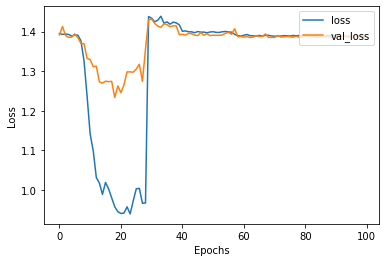

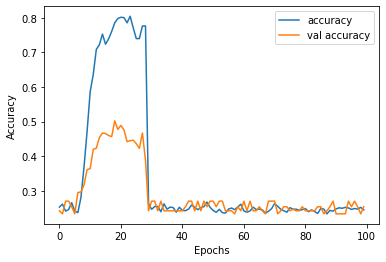

In [28]:
plot_learning_curve(history)

In [ ]:
test_x = tokenizer(
    text=test['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y=ytest
)

In [ ]:
model_eval

In [ ]:
def prediction(model,tokenizer,input_string):
    
    padded_tokens = tokenizer(
    text=[input_string],
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)
    
    my_prediction = model.predict(padded_tokens['input_ids'])
    print(my_prediction)
    conversion_dict = {0:'joy',1:'fear',2:'anger',3:'sadness'}
    
    return conversion_dict[np.argmax(prediction)]

In [ ]:
prediction(model, tokenizer, 'मै बहुत दुखी हूँ')

In [ ]:
# i am overjoyed
prediction(model, tokenizer, 'நான் மிகவும் மகிழ்ச்சியடைகிறேன்')

In [ ]:
# i am very annoyed at you
prediction(model, tokenizer, 'sono molto seccato con te')

In [ ]:
#someone is staring at me
prediction(model, tokenizer, "quelqu'un me regarde")

In [ ]:
# i saw a ghost
prediction(model, tokenizer, "j'ai vu un fantôme")